In [1]:
#CatBoost Model
from catboost import CatBoostClassifier, cv, Pool, metrics
import hyperopt
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import shap
from sklearn.utils import resample

## Creating CatBoost Model without PCA


In [2]:
#importing processed data and seperating into predictor and target variables
processed_data = pd.read_csv("processed_data.csv")
processed_data = processed_data.drop(columns = 'Unnamed: 0')
diabetes_data_predictors = processed_data

diabetes_data_predictors = processed_data.drop(columns="readmitted")

#splitting processed data into training and testing sets
X, y = diabetes_data_predictors, processed_data["readmitted"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [3]:
#performing undersampling to reduce proportion of majority class - starts by creating dataframe for X and y
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

X = pd.concat([X_train, y_train], axis=1)

not_readmitted = X[X.readmitted==0]
readmitted = X[X.readmitted==1]

#performing undersampling by reducing proportion of class imbalance - allows for better performance
not_readmitted_sampled = resample(not_readmitted,
                                replace = False, 
                                n_samples = int(len(readmitted) * 1.25),
                                random_state = 42)

downsampled = pd.concat([not_readmitted_sampled, readmitted])

#manipulating and setting up objects
y_train = downsampled.readmitted
X_train = downsampled.drop('readmitted', axis=1)

#doing another train-test split to ensure model is trained in appropriate environment to prevent risk of overfitting
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

In [4]:
#identifying best parameters for catboost with dataset that has class imbalances - computationally intensive so do not run
#categorical_features_indices = np.where(X.dtypes != float)[0]

#identifying best parameters for catboost
#def hyperopt_objective(params):
#    catboost_model = CatBoostClassifier(
 #       l2_leaf_reg=(params['l2_leaf_reg']),
  #      learning_rate=params['learning_rate'],
   #     iterations=500,
    #    eval_metric=metrics.Accuracy(),
     #   random_seed=40,
      #  verbose=False,
       # loss_function=metrics.Logloss(),
    #)

    #cv_data = cv(
     #   Pool(X_train, y_train, cat_features=categorical_features_indices),
      #  catboost_model.get_params(),
       # logging_level='Silent',
    #)
   # best_accuracy = np.max(cv_data['test-Accuracy-mean'])

#    return 1 - best_accuracy

In [5]:
#using hyperopt to get best parameters for catboost models - dont run as computationally intensive
#from numpy.random import default_rng
#params_space = {
   # 'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    #'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
#}

#trials = hyperopt.Trials()

#best = hyperopt.fmin(
 #   hyperopt_objective,
  #  space = params_space,
   # algo=hyperopt.tpe.suggest,
    #max_evals=50,
    #trials=trials,
    #rstate=default_rng(123)
#)

#print(best)

In [6]:
#creating catboost model with bes possible parameters - optimizes performance - dont run as it will be too intensive
#getting cv with our best parameters
#catboost_best_model = CatBoostClassifier(
 #   l2_leaf_reg=(best['l2_leaf_reg']),
  #  learning_rate=best['learning_rate'],
   # iterations=500,
    #eval_metric=metrics.Accuracy(),
    #random_seed=42,
    #verbose=False,
    #scale_pos_weight=1.5,
    #loss_function=metrics.Logloss(),
#)

#cv_data = cv(Pool(X_train, y_train, cat_features=categorical_features_indices), catboost_best_model.get_params())

In [7]:
# training model on the training dataset now
#catboost_best_model.fit(X_train, y_train, cat_features=categorical_features_indices)

#creating simple catboost model while incorporating tuned parameters
catboost_model = CatBoostClassifier(random_state=42, max_depth=3, scale_pos_weight=1.5)
catboost_model.fit(X_train, y_train, verbose = False)

In [8]:
#predicting performance on testing dataset that has balanced class
y_pred = catboost_model.predict(X_val)
y_pred_proba_catboost = catboost_model.predict_proba(X_val)[:,1]

#calculating accuracy
accuracy_catboost = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy_catboost:.4f}")

#calculating AUC
auc_catboost = roc_auc_score(y_val, y_pred)
#print(f"ROC AUC: {auc_catboost:.4f}")

#classification report for catboost
print("\nClassification Report:\n", classification_report(y_val, y_pred))

Accuracy: 0.5897

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.51      0.58      3322
           1       0.53      0.69      0.60      2662

    accuracy                           0.59      5984
   macro avg       0.60      0.60      0.59      5984
weighted avg       0.61      0.59      0.59      5984



In [9]:
#predicting performance of model on original testing set
y_pred_v = catboost_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred_v))


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.50      0.65     17410
           1       0.14      0.67      0.24      2201

    accuracy                           0.52     19611
   macro avg       0.53      0.59      0.44     19611
weighted avg       0.84      0.52      0.60     19611



## Creating CatBoost Model with PCA

In [10]:
#performing catboost with PCA now

#creating new objects and repeating analysis starting with train-test split
X1,y1 = diabetes_data_predictors, processed_data["readmitted"]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=40)

#same undersampling technique
X1_train = pd.DataFrame(X1_train)
y1_train = pd.DataFrame(y1_train)

X1 = pd.concat([X1_train, y1_train], axis=1)

not_readmitted_1 = X1[X1.readmitted==0]
readmitted_1 = X1[X1.readmitted==1]

not_readmitted_sampled_1 = resample(not_readmitted_1,
                                replace = False, 
                                n_samples = int(len(readmitted_1) * 1.25),
                                random_state = 42)

downsampled_1 = pd.concat([not_readmitted_sampled_1, readmitted_1])


y1_train = downsampled_1.readmitted
X1_train = downsampled_1.drop('readmitted', axis=1)

#second train test split
X1_train, X1_val, y1_train, y1_val = train_test_split(X1_train, y1_train, test_size = 0.3, random_state = 42)

#scaling features for PCA
scaler = StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_val)

#PCA to extract best components
pca = PCA(0.95)  # Keep 10 principal components
X1_train_pca = pca.fit_transform(X1_train_scaled)
X1_test_pca = pca.transform(X1_test_scaled)

In [11]:
#Creating catboost model with PCA
catboost_model_pca = CatBoostClassifier(random_state=42, max_depth=3, scale_pos_weight=1.5)
catboost_model_pca.fit(X1_train_pca[:,:2], y1_train, verbose = False)

In [12]:
#predicting performance of Catboost + PCA on testing dataset
y_pred_pca = catboost_model_pca.predict(X1_test_pca)

#calculating accuracy
accuracy_catboost_pca = accuracy_score(y1_val, y_pred_pca)
print(f"Accuracy: {accuracy_catboost_pca:.4f}")

#calculating AUC
auc_catboost_pca = roc_auc_score(y1_val, y_pred_pca)
#print(f"ROC AUC: {auc_catboost:.4f}")

#classification report for catboost
print("\nClassification Report:\n", classification_report(y1_val, y_pred_pca))

Accuracy: 0.4958

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.23      0.34      3322
           1       0.46      0.83      0.59      2662

    accuracy                           0.50      5984
   macro avg       0.54      0.53      0.46      5984
weighted avg       0.55      0.50      0.45      5984



The AUC score for this logistic regression model is 0.6404713290401489
The AUC score for this logistic regression model is 0.5485810282383093


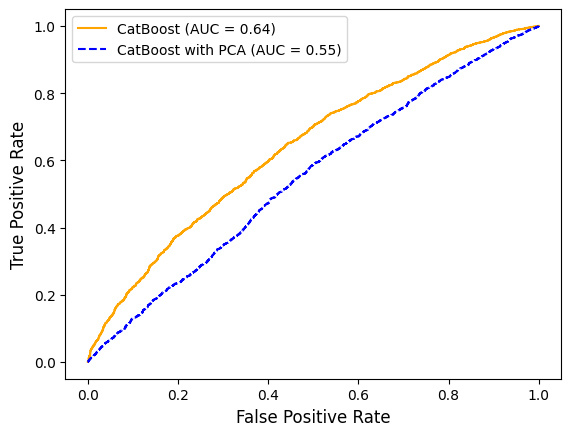

In [13]:
#ROC curve for CatBoost vs CatBoost + PCA

X_test_probs = catboost_model.predict_proba(X_val)[::,1]

#computing ROC and AUC for lcatboost model with OCA
lr_fpr, lr_tpr, _ = roc_curve(y_val, X_test_probs, pos_label=1)
lr_auc = roc_auc_score(y_val, X_test_probs)
print("The AUC score for this logistic regression model is", lr_auc)

#comparing performance between CatBoost with and without PCA
X_test_probs_pca = catboost_model_pca.predict_proba(X1_test_pca)[::,1]
#computing ROC and AUC for logistic regression
lr_fpr_pca, lr_tpr_pca, _ = roc_curve(y1_val, X_test_probs_pca, pos_label=1)
lr_auc_pca = roc_auc_score(y1_val, X_test_probs_pca)
print("The AUC score for this logistic regression model is", lr_auc_pca)

#ROC curve for 2 catboost models
plt.plot(lr_fpr, lr_tpr, label=f'CatBoost (AUC = {lr_auc:.2f})', color='orange', linestyle = '-')
plt.plot(lr_fpr_pca, lr_tpr_pca, label=f'CatBoost with PCA (AUC = {lr_auc_pca:.2f})', color = 'blue', linestyle="--")
plt.legend()
plt.xlabel("False Positive Rate", size=12)
plt.ylabel("True Positive Rate", size=12)
plt.savefig("catboost_auc.png", dpi=300)

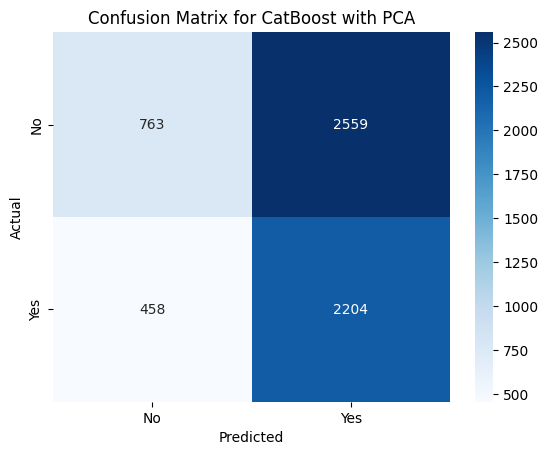

In [14]:
#confusion matrix for catboost with pca
cm = confusion_matrix(y1_val, y_pred_pca)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for CatBoost with PCA')
plt.show()

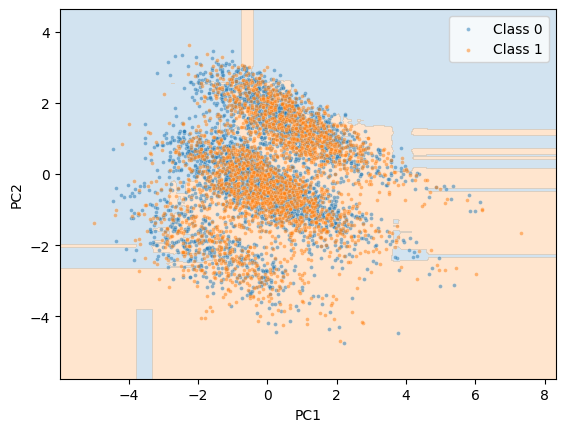

In [15]:
#Creating a decision boundary plot

#defining the plot boundaries using the testing set - this generates grid plots that covers the PCA space
xx, yy = np.meshgrid(
    np.linspace(X1_test_pca[:, 0].min() - 1, X1_test_pca[:, 0].max() + 1, 200),
    np.linspace(X1_test_pca[:, 1].min() - 1, X1_test_pca[:, 1].max() + 1, 200)
)

#flattening the grid and making predictions using the PCA built model
grid = np.c_[xx.ravel(), yy.ravel()]
Z = catboost_model_pca.predict_proba(grid)[:, 1] 
Z = Z.reshape(xx.shape)

#plotting decision map contours to predict classification space
plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.2, colors=['tab:blue', 'tab:orange'])

#scatter plot of the testing set - these are actual points that reflect outcome which is not readmitted vs readmitted
sns.scatterplot(x=X1_test_pca[y1_val == 0][:, 0], y=X1_test_pca[y1_val == 0][:, 1], 
                s=8, alpha=0.5, label="Class 0", color='tab:blue')
sns.scatterplot(x=X1_test_pca[y1_val == 1][:, 0], y=X1_test_pca[y1_val == 1][:, 1], 
                s=8, alpha=0.5, label="Class 1", color='tab:orange')

#plotting and saving the decision boundary plot
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.savefig("catboost_pca.png", dpi=300)

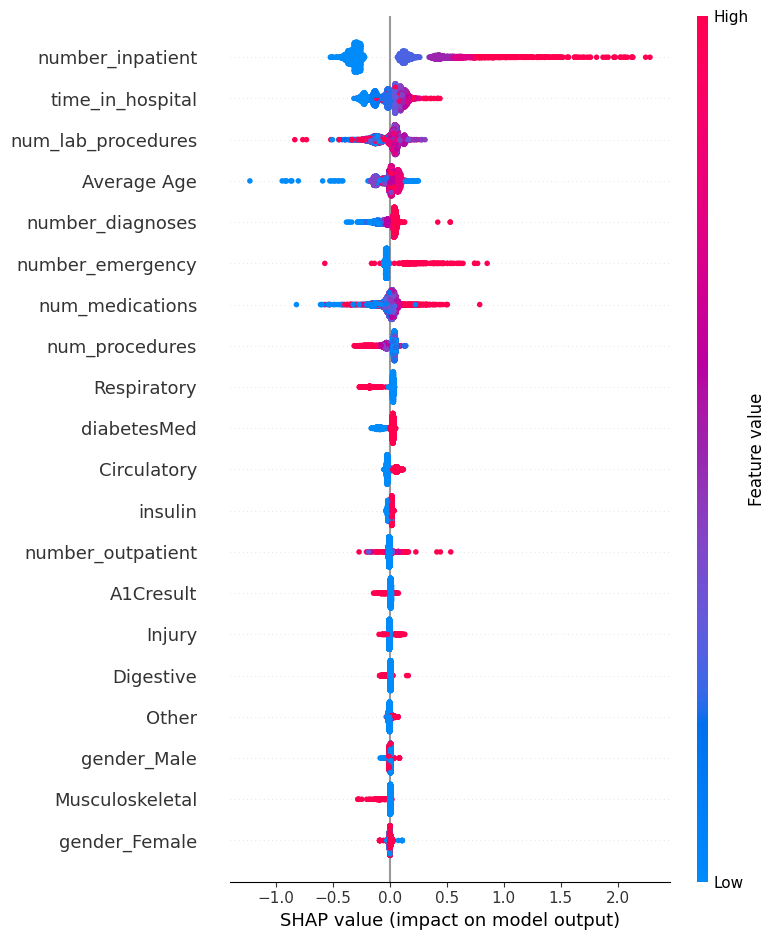

<Figure size 640x480 with 0 Axes>

In [16]:
#using shap for feature importance in the CatBoost Model

#creating a shap explainer
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values, X_val)
plt.savefig("catboost_summary.png", dpi=300)

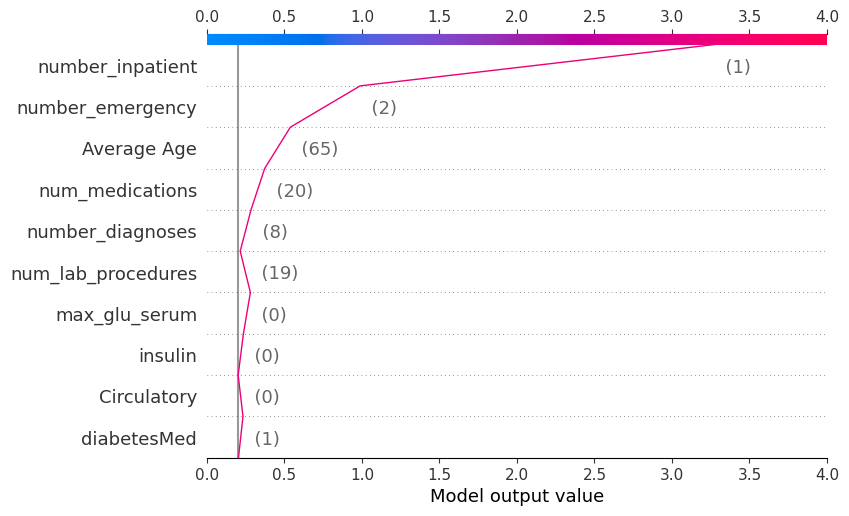

<Figure size 640x480 with 0 Axes>

In [17]:
predictions = catboost_model.predict_proba(X_val)[:, 1]  # Get probabilities for class 1
i = np.argmax(predictions)
top_n = 10  # Number of features to show
shap_values_instance = np.abs(shap_values[i])  # Get absolute values
top_features = np.argsort(shap_values_instance)[-top_n:]  # Select top 10 feature indices

# Filter SHAP values and feature names
shap_values_top_n = shap_values[i][top_features]
X_test_top_n = X_test.iloc[i, top_features]

# Generate the decision plot with only top 10 features
plt.figure(figsize=(10,6))
shap.decision_plot(explainer.expected_value, shap_values_top_n, X_test_top_n, xlim=(0,4))
plt.savefig("catboost_decision.pdf", dpi=300)
plt.show()